# The Power Spectrum of Survey Data

In this notebook, we explore the functionality of the ``ConvolvedFFTPower`` algorithm, which computes the power spectrum multipoles $P_\ell(k)$ for data from a survey that includes non-trivial selection effects. The output of the algorithm is the true multipoles of the data, convoled with the window function of the survey. 

The input data for this algorithm is assumed to be from an observational survey, with the position coordinates specified in terms of right ascension, declination, and redshift.

**Note**

The data used in this notebook is not realistic -- rather, we choose the simplicity of generating mock data to help users get up and running quickly. Although the end results are not cosmologically interesting, we use the mock data to help illustrate the various steps necessary to use the ``ConvolvedFFTPower`` algorithm properly.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from nbodykit.lab import *
from nbodykit import setup_logging, style

from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib.pyplot as plt
plt.style.use(style.notebook)

In [3]:
setup_logging()

## Initalizing Mock Data

We start by generating mock catalogs to mimic the "data" and "randoms" catalogs needed by the ``ConvolvedFFTPower`` algorithm. Here, the "data" catalog usually gives the information about the galaxy objects, and the "randoms" catalog is a catalog of synthetic objects without any cosmological clustering signal. The "randoms" usually have a higher number density than the "data" and are a Monte Carlo representation of the survey volume. 

In this notebook, we construct our fake "data" and "randoms" catalogs simply by generating uniformly distributed 
right ascension and declination values within a region of the sky, with redshifts drawn from a Gaussian distribution with $\mu=0.5$ and $\sigma=0.1$. 

In [4]:
NDATA = 50000

# initialize data and randoms catalogs
data = RandomCatalog(NDATA, seed=42)
randoms = RandomCatalog(NDATA*10, seed=84)

# add the (ra, dec, z) columns
for s in [data, randoms]:
    s['z']   = s.rng.normal(loc=0.5, scale=0.1, size=s.size)
    s['ra']  = s.rng.uniform(low=110, high=260, size=s.size)
    s['dec'] = s.rng.uniform(low=-3.6, high=60., size=s.size)

## Adding the Cartesian Coordinates

Next, we add the ``Position`` column to both the "data" and "randoms" by converting from sky coordinates to Cartesian coordinates, using the helper function ``transform.SkyToCartesian``. The redshift to comoving distance transformation requires a cosmology instance, so we first initialize our desired cosmology parameters. 

In [5]:
# specify our cosmology
cosmo = cosmology.Cosmology(h=0.7).match(Omega0_m=0.31)

# add Cartesian position column
data['Position'] = transform.SkyToCartesian(data['ra'], data['dec'], data['z'], cosmo=cosmo)
randoms['Position'] = transform.SkyToCartesian(randoms['ra'], randoms['dec'], randoms['z'], cosmo=cosmo)

## Specifying the "data" $n(z)$

The ``ConvolvedFFTPower`` algorithm requires the number density as a function of redshift for the "data" catalog. Here, we use the ``RedshiftHistogram`` algorithm to compute the redshift histogram of the "randoms" catalog, and then re-normalize the number density to that of the "data" catalog. 

[ 000000.13 ]   0: 10-23 09:45  RedshiftHistogram INFO     using Scott's rule to determine optimal binning; h = 4.40e-03, N_bins = 207
[ 000000.16 ]   0: 10-23 09:45  RedshiftHistogram INFO     using cosmology <nbodykit.cosmology.cosmology.Cosmology object at 0x11cbad208> to compute volume in units of (Mpc/h)^3
[ 000000.16 ]   0: 10-23 09:45  RedshiftHistogram INFO     sky fraction used in volume calculation: 0.1500


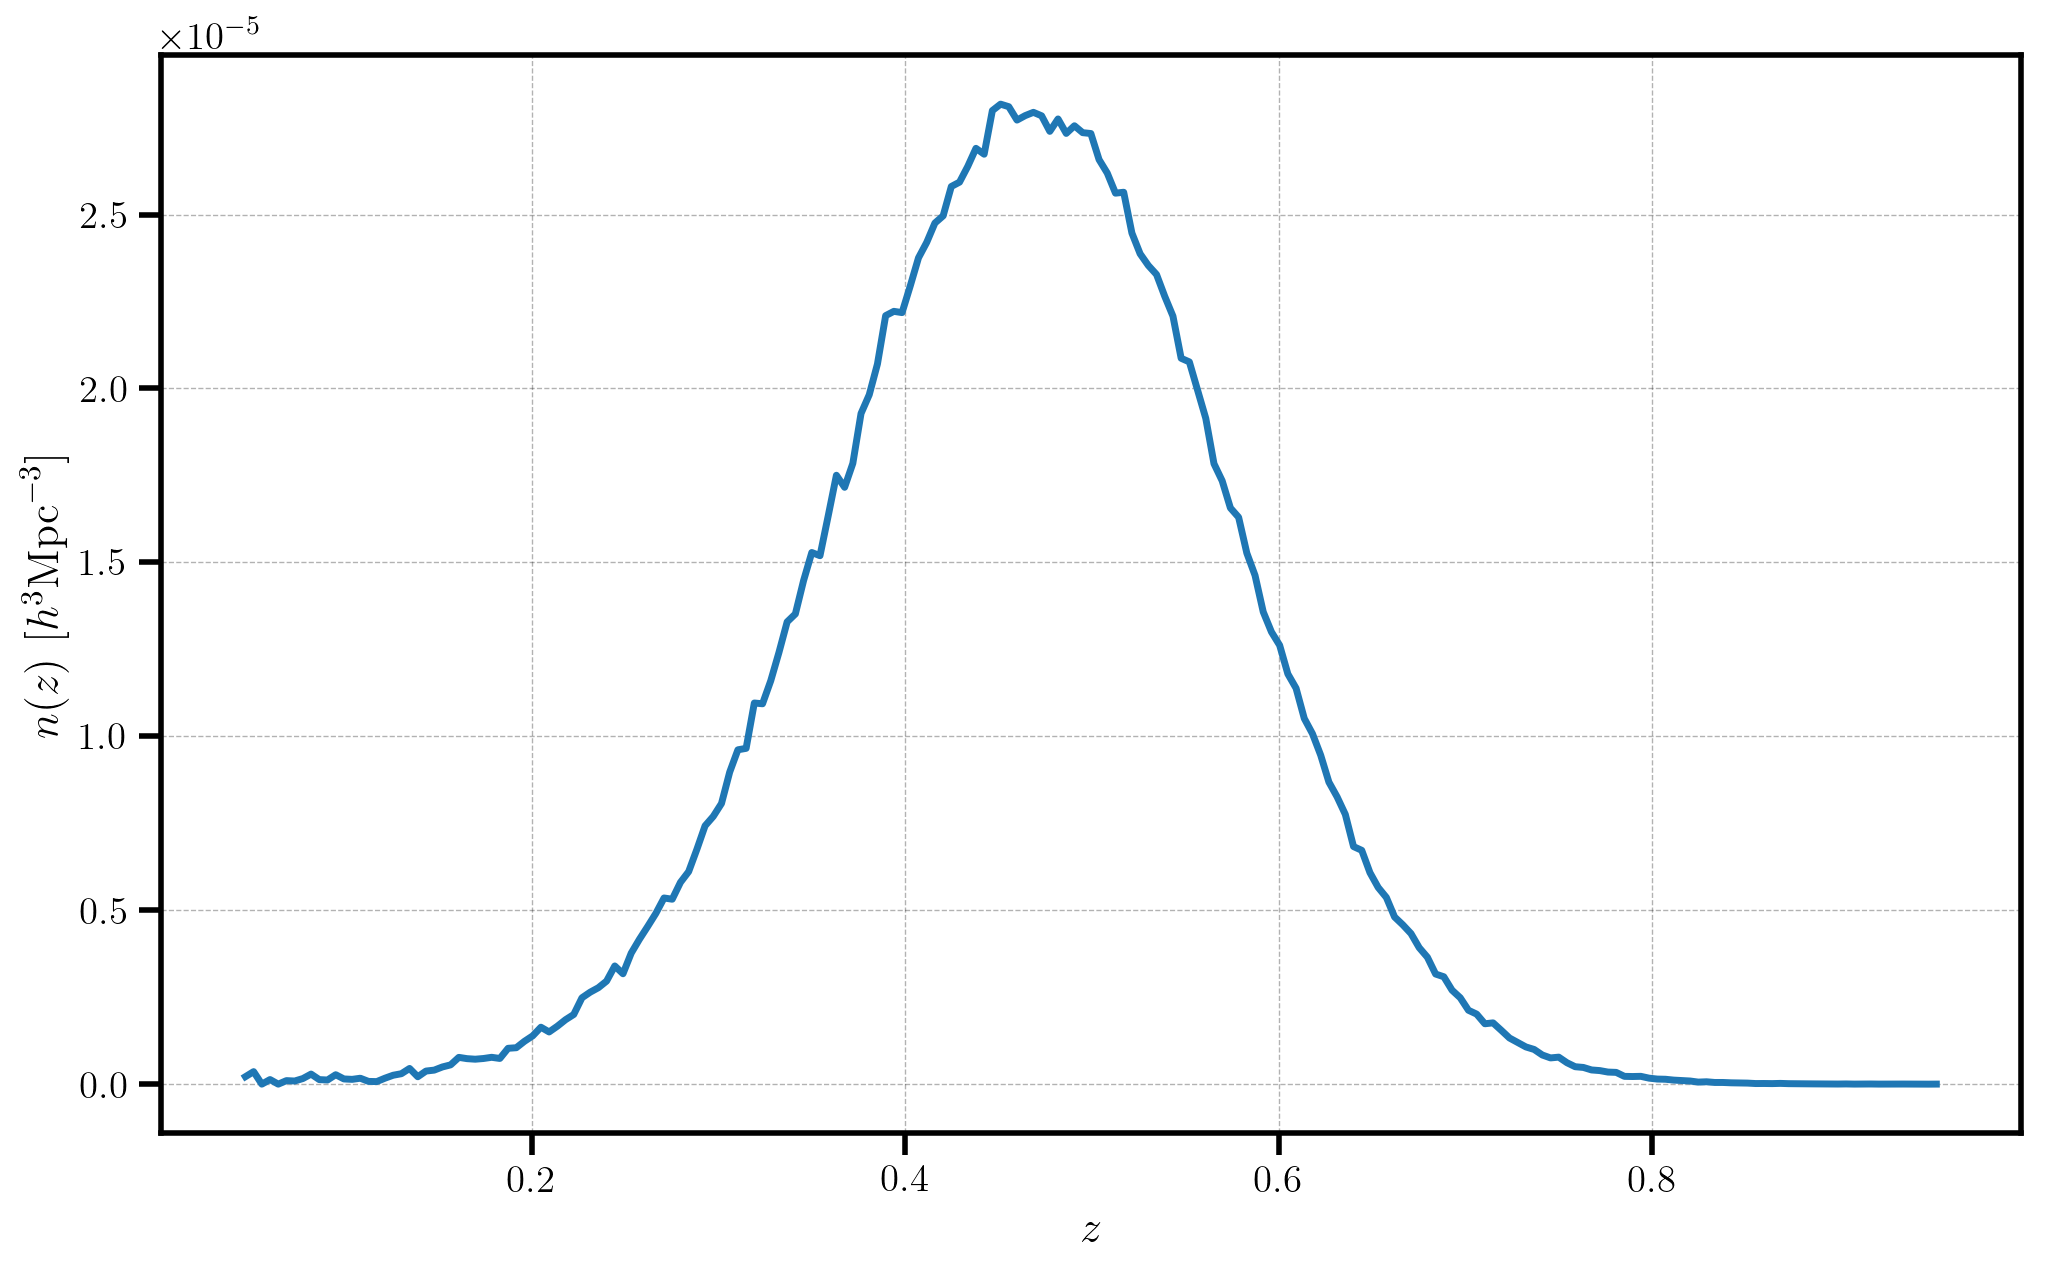

In [6]:
# the sky fraction, used to compute volume in n(z)
FSKY = 0.15 # a made-up value

# compute n(z) from the randoms
zhist = RedshiftHistogram(randoms, FSKY, cosmo, redshift='z')

# re-normalize to the total size of the data catalog
alpha = 1.0 * data.csize / randoms.csize

# add n(z) from randoms to the FKP source
nofz = InterpolatedUnivariateSpline(zhist.bin_centers, alpha*zhist.nbar)

# plot
plt.plot(zhist.bin_centers, alpha*zhist.nbar)
plt.xlabel(r"$z$", fontsize=16)
plt.ylabel(r"$n(z)$ $[h^{3} \mathrm{Mpc}^{-3}]$", fontsize=16)

In this figure, note that the measured $n(z)$ for the data closely resembles the input distribution we used: a Gaussian distribution with $\mu=0.5$ and $\sigma=0.1$. 

Next, we initialize the ``FKPCatalog``, which combines the "data" and "randoms" catalogs into a single object. Columns are now available in the ``FKPCatalog`` prefixed by either "data/" or "randoms/".

In [7]:
# initialize the FKP source
fkp = FKPCatalog(data, randoms)

# print out the columns
print("columns in FKPCatalog = ", fkp.columns)

columns in FKPCatalog =  ['data/FKPWeight', 'data/Position', 'data/Selection', 'data/Value', 'data/Weight', 'data/dec', 'data/ra', 'data/z', 'randoms/FKPWeight', 'randoms/Position', 'randoms/Selection', 'randoms/Value', 'randoms/Weight', 'randoms/dec', 'randoms/ra', 'randoms/z']


And we add the $n(z)$ column to both the "data" and "randoms", using the appropriate redshift column to compute the results.

In [8]:
# add the n(z) columns to the FKPCatalog
fkp['randoms/NZ'] = nofz(randoms['z'])
fkp['data/NZ'] = nofz(data['z'])

## Adding FKP Weights

Here, we add a column ``FKPWeight`` that gives the appropriate FKP weight for each catalog. The FKP weights are given by:

$$
w_\mathrm{FKP} = \frac{1}{1 + n(z)P_0}.
$$

Here, we use a value of $P_0 = 10^4 \ h^{-3} \mathrm{Mpc}^3$.

In [9]:
fkp['data/FKPWeight'] = 1.0 / (1 + fkp['data/NZ'] * 1e4)
fkp['randoms/FKPWeight'] = 1.0 / (1 + fkp['randoms/NZ'] * 1e4)

## Adding Completeness Weights


The ``ConvolvedFFTPower`` algorithm also supports the use of completeness weights, which weight the number density fields of the "data" and "randoms" catalogs. Here, we add random weights to both catalogs as the ``Weight`` column.

Completeness weights change the number density field such that the weighted number density field on the mesh is equal to $n'(\mathbf{r}) = w_c(\mathbf{r}) n(\mathbf{r})$, where $w_c$ represents the completeness weights.

In [10]:
fkp['data/Weight'] = numpy.random.random(size=data.size)
fkp['randoms/Weight'] = numpy.random.random(size=randoms.size)

## Computing the Multipoles

To compute the multipoles, first we convert our ``FKPCatalog`` to a mesh object, specifying the number of mesh cells per side, as well as the names of the $n(z)$ and weight columns. 

If a Cartesian box size is not specified by the user, 
the size will be computed from the maximum extent of the ``Position`` column automatically.

In [11]:
mesh = fkp.to_mesh(Nmesh=256, nbar='NZ', comp_weight='Weight', fkp_weight='FKPWeight')

[ 000003.40 ]   0: 10-23 09:45  FKPCatalog      INFO     BoxSize = [ 2002.  3140.  2039.]
[ 000003.40 ]   0: 10-23 09:45  FKPCatalog      INFO     cartesian coordinate range: [-1984.39087457 -1127.49112553  -119.74976004] : [  -22.39803261  1950.21971177  1878.56913778]
[ 000003.40 ]   0: 10-23 09:45  FKPCatalog      INFO     BoxCenter = [-1003.39445359   411.36429312   879.40968887]


Now, we are able to compute the desired multipoles. Here, we compute the $\ell=0,2,$ and $4$ multipoles using a wavenumber spacing of $k = 0.005$ $h/\mathrm{Mpc}$. The maximum $k$ value computed is set by the Nyquist frequency of the mesh, $k_\mathrm{max} = k_\mathrm{Nyq} = \pi N_\mathrm{mesh} / L_\mathrm{box}$.

In [12]:
# compute the multipoles
r = ConvolvedFFTPower(mesh, poles=[0,2,4], dk=0.005, kmin=0.01)

[ 000003.43 ]   0: 10-23 09:45  ConvolvedFFTPower INFO     using compensation function CompensateCICAliasing for source 'first'
[ 000003.43 ]   0: 10-23 09:45  ConvolvedFFTPower INFO     using compensation function CompensateCICAliasing for source 'second'
[ 000005.45 ]   0: 10-23 09:45  CatalogMesh     INFO     painted 500000 out of 500000 objects to mesh
[ 000005.45 ]   0: 10-23 09:45  CatalogMesh     INFO     mean particles per cell is 0.0125128
[ 000005.46 ]   0: 10-23 09:45  CatalogMesh     INFO     sum is 209930 
[ 000005.46 ]   0: 10-23 09:45  CatalogMesh     INFO     normalized the convention to 1 + delta
[ 000005.58 ]   0: 10-23 09:45  CatalogMesh     INFO     painted 50000 out of 50000 objects to mesh
[ 000005.58 ]   0: 10-23 09:45  CatalogMesh     INFO     mean particles per cell is 0.00125039
[ 000005.59 ]   0: 10-23 09:45  CatalogMesh     INFO     sum is 20978.1 
[ 000005.59 ]   0: 10-23 09:45  CatalogMesh     INFO     normalized the convention to 1 + delta
[ 000005.66 ]  

The meta-data computed during the calculation is stored in ``attrs`` dictionary. See [the documentation](../algorithms/survey-power.ipynb#the-meta-data) for more information.

In [13]:
for key in r.attrs:
    print("%s = %s" % (key, str(r.attrs[key])))

poles = [0, 2, 4]
dk = 0.005
kmin = 0.01
use_fkp_weights = False
P0_FKP = None
Nmesh = [256 256 256]
BoxSize = [ 2002.  3140.  2039.]
BoxPad = [ 0.02  0.02  0.02]
BoxCenter = [-1003.39445359   411.36429312   879.40968887]
mesh.window = cic
mesh.interlaced = False
alpha = 0.099863986751
data.norm = 0.329660082907
randoms.norm = 0.330691172521
shotnoise = 39180.2781119
randoms.N = 500000
randoms.W = 250445.136865
randoms.num_per_cell = 0.012512773943
data.N = 50000
data.W = 25010.4498298
data.num_per_cell = 0.00125039063324
data.seed = 42
randoms.seed = 84


The measured multipoles are stored in the ``poles`` attribute. Below, we plot the monopole, quadrupole, and hexadecapole, making sure to subtract out the shot noise value from the monopole.

(0.01, 0.3)

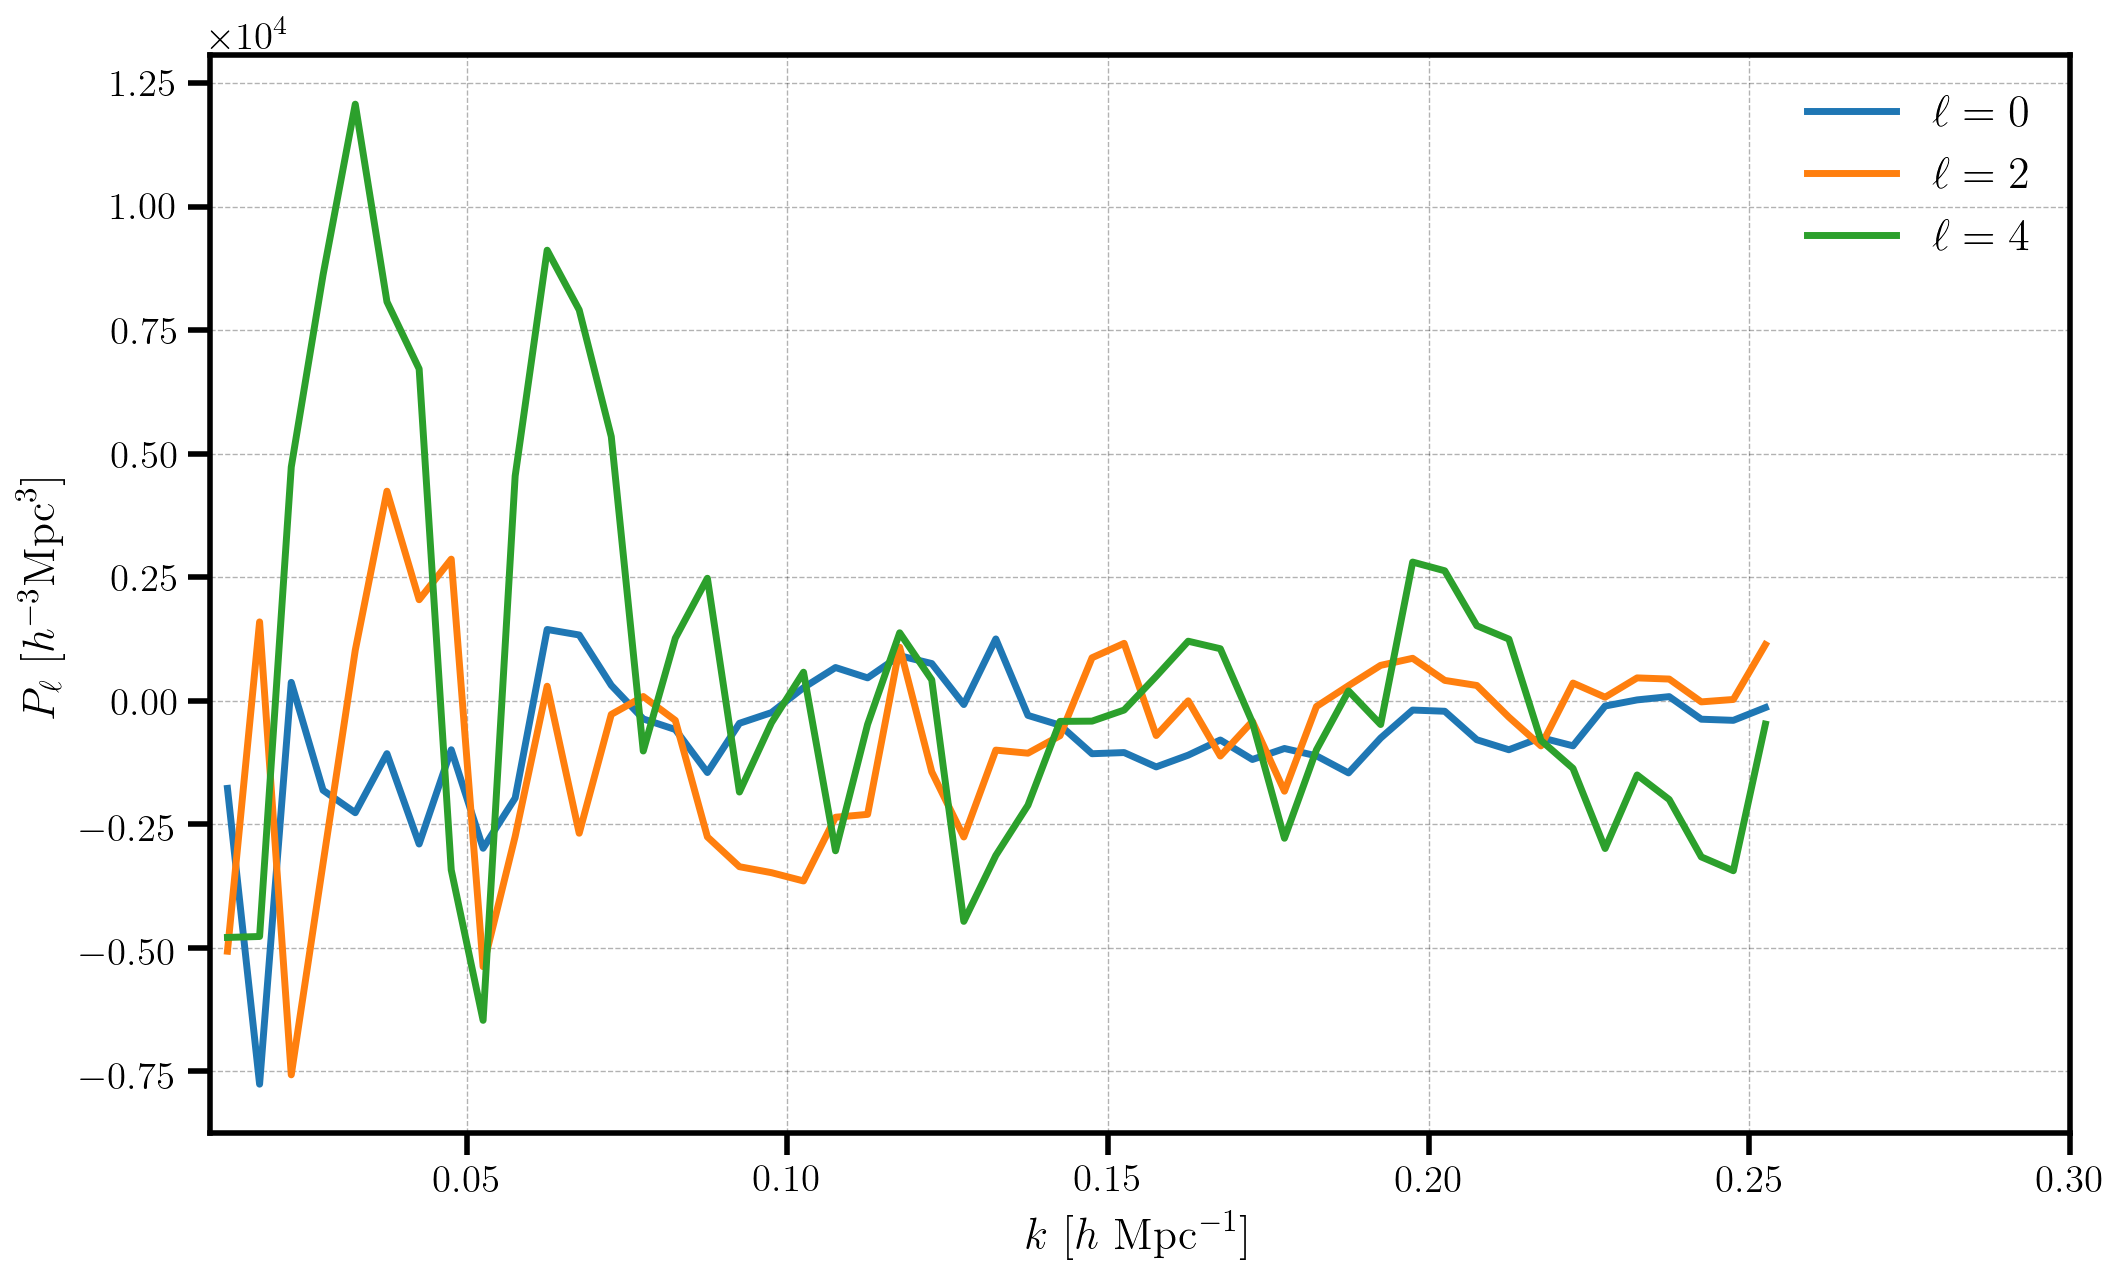

In [14]:
poles = r.poles

for ell in [0, 2, 4]:
    label = r'$\ell=%d$' % (ell)
    P = poles['power_%d' %ell].real
    if ell == 0: P = P - poles.attrs['shotnoise']
    plt.plot(poles['k'], P, label=label)

# format the axes
plt.legend(loc=0)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P_\ell$ [$h^{-3} \mathrm{Mpc}^3$]")
plt.xlim(0.01, 0.3)

Note that, as expected, there is no measurably cosmological signal, since the input catalogs were simply uniformly distributed objects on the sky. 